In [8]:
import numpy as np
import pandas as pd
import copy
import scipy.stats as st
import math
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [9]:
mu, sigma = 10, 5
s1 = st.norm(mu, sigma).rvs(100000)
s2 = st.norm(mu-4, sigma+4).rvs(100000)

df_1 = pd.DataFrame(s1,columns=["feat"]  )
df_1['Y'] = 0

df_2 = pd.DataFrame(s2,columns=["feat"]  )
df_2['Y'] = 1
df = pd.concat([df_1,df_2],axis=0).reset_index(drop=True)

## Let's take a look on these two distributions

In [10]:
def plot_feature_distribution(df1, df2, label1, label2, features,plot_rows,plot_cols):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(20,15))

    for feature in features:
        i += 1
        plt.subplot(plot_rows,plot_cols,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=20)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=15, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=15)
    plt.show();

<Figure size 432x288 with 0 Axes>

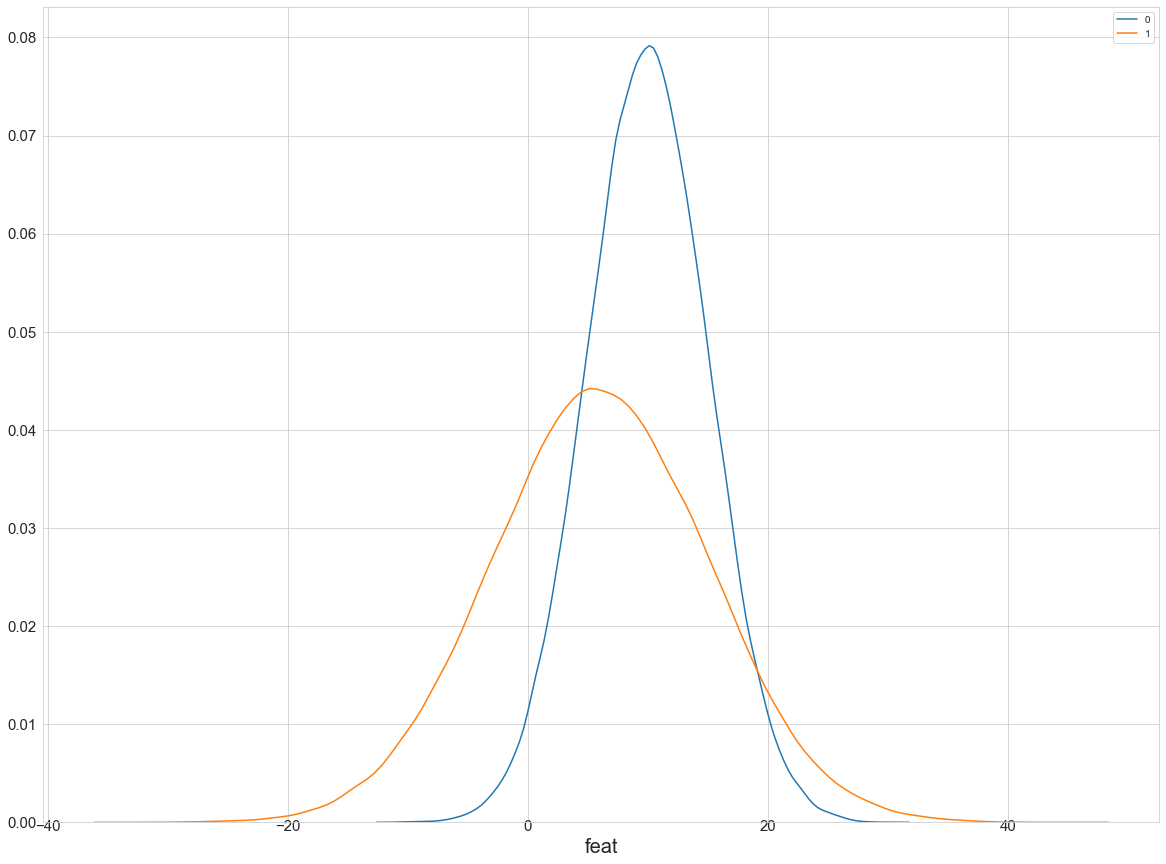

In [12]:
t0 = df.loc[df['Y'] == 0]
t1 = df.loc[df['Y'] == 1]
feature_cols = [col for col in df.columns if col != 'Y']
plot_feature_distribution(t0, t1, '0', '1', feature_cols,1,1)

# Kernel Magic Start!

### Step 1: fit kernel pdf  in a diction|ary 

In [13]:
#定義x步長,越大feature顆粒度越粗,但還是要參考raw feature的區間寬度
xlen =0.5 

def feat_fit_func(df,X,X_len): #創造mapping dict
    feat_X = df.sort_values(by=[X]).reset_index(drop=True)[X].to_numpy()
    interval_n = math.ceil((feat_X.max()-feat_X.min())/X_len) #區間數
    feat_Xmin = feat_X.min() #最小值
    
    print("interval_n: ",interval_n)
    print("feat_Xmin: ",feat_Xmin)

    for i in range(interval_n,-1,-1):
        feat_X[(feat_Xmin + (i)*X_len <= feat_X) &\
               (feat_X < feat_Xmin + (i+1)*X_len) ] = feat_Xmin + (i+1)*X_len #向右靠齊
    unique, counts = np.unique(feat_X, return_counts=True)
    counts_propotion = counts/len(feat_X)

    my_dict=defaultdict(int)
    for i in range(len(unique)):
        my_dict[unique[i]]=counts_propotion[i]

    return my_dict

In [14]:
feat_dict_0 = feat_fit_func(df[df['Y']==0].reset_index(drop=True),'feat',xlen) #P(X|Y=0)的pdf
feat_dict_1 = feat_fit_func(df[df['Y']==1].reset_index(drop=True),'feat',xlen) #P(X|Y=1)的pdf

interval_n:  83
feat_Xmin:  -11.03167027816902
interval_n:  158
feat_Xmin:  -33.29290428308403


In [21]:
feat_dict_0

defaultdict(int,
            {-10.53167027816902: 1e-05,
             -10.03167027816902: 3e-05,
             -9.53167027816902: 2e-05,
             -9.03167027816902: 3e-05,
             -8.53167027816902: 4e-05,
             -8.03167027816902: 4e-05,
             -7.53167027816902: 6e-05,
             -7.03167027816902: 8e-05,
             -6.53167027816902: 0.00011,
             -6.03167027816902: 0.0002,
             -5.53167027816902: 0.00028,
             -5.03167027816902: 0.00037,
             -4.53167027816902: 0.00046,
             -4.03167027816902: 0.00074,
             -3.5316702781690203: 0.0009,
             -3.0316702781690203: 0.00125,
             -2.5316702781690203: 0.00145,
             -2.0316702781690203: 0.00207,
             -1.5316702781690203: 0.00246,
             -1.0316702781690203: 0.00311,
             -0.5316702781690203: 0.00406,
             -0.03167027816902035: 0.00445,
             0.46832972183097965: 0.00651,
             0.9683297218309797: 0.00

In [22]:
feat_dict_1

defaultdict(int,
            {-32.79290428308403: 1e-05,
             -31.292904283084027: 1e-05,
             -28.792904283084027: 2e-05,
             -28.292904283084027: 3e-05,
             -27.792904283084027: 3e-05,
             -27.292904283084027: 1e-05,
             -26.792904283084027: 3e-05,
             -26.292904283084027: 2e-05,
             -25.792904283084027: 8e-05,
             -25.292904283084027: 7e-05,
             -24.792904283084027: 6e-05,
             -24.292904283084027: 0.0001,
             -23.792904283084027: 6e-05,
             -23.292904283084027: 0.0001,
             -22.792904283084027: 0.00014,
             -22.292904283084027: 8e-05,
             -21.792904283084027: 0.00015,
             -21.292904283084027: 0.00023,
             -20.792904283084027: 0.00024,
             -20.292904283084027: 0.0003,
             -19.792904283084027: 0.00029,
             -19.292904283084027: 0.00028,
             -18.792904283084027: 0.00044,
             -18.2929042

### Step 2: transform feature into kernel feature, return kernel feature 

In [15]:
#fit 固定範圍,transform就可以直接用
def feat_transform_func(df,X,X_len,fit_dict): #放入df & mapping dict, Return Feat pdf
    feat_X = copy.deepcopy(df[X]).to_numpy()
    
    #區間+1才會是原長度
    interval_n = math.ceil((max(list(fit_dict.keys())) - min(list(fit_dict.keys())) )/X_len)+1 
    feat_Xmin = min(list(fit_dict.keys()))-X_len #向右靠齊所以要往前推一格

    for i in range(interval_n,-1,-1):
        feat_X[(feat_Xmin + (i)*X_len <= feat_X) &\
               (feat_X < feat_Xmin + (i+1)*X_len) ] = feat_Xmin + (i+1)*X_len #向右靠齊
    
    return feat_X

### Step 3: mapping kernel feature to kernel dictionary, return kernel pdf 

In [16]:
df['feat_Y=0'] = feat_transform_func(df,'feat',xlen,feat_dict_0)
df['feat_Y=0_pdf'] = [feat_dict_0[i] for i in df['feat_Y=0']]

df['feat_Y=1'] = feat_transform_func(df,'feat',xlen,feat_dict_1)
df['feat_Y=1_pdf'] = [feat_dict_1[i] for i in df['feat_Y=1']]

### Step 4: mapping kernel feature to kernel dictionary, return kernel pdf 

In [17]:
df['diff_pdf'] = df['feat_Y=1_pdf'] - df['feat_Y=0_pdf']

#### Magic df

In [18]:
df.head(10)

,feat,Y,feat_Y=0,feat_Y=0_pdf,feat_Y=1,feat_Y=1_pdf,diff_pdf
0,13.006046,0,13.46833,0.03228,13.207096,0.01674,-0.01554
1,6.256392,0,6.46833,0.02918,6.707096,0.02173,-0.00745
2,6.260087,0,6.46833,0.02918,6.707096,0.02173,-0.00745
3,5.494593,0,5.96833,0.02747,5.707096,0.02262,-0.00485
4,-0.275422,0,-0.03167,0.00445,0.207096,0.01774,0.01329
5,7.320497,0,7.46833,0.03531,7.707096,0.02197,-0.01334
6,4.535285,0,4.96833,0.02327,4.707096,0.02271,-0.00056
7,20.921482,0,20.96833,0.00408,21.207096,0.00597,0.00189
8,12.943161,0,12.96833,0.03363,13.207096,0.01674,-0.01689
9,18.914151,0,18.96833,0.00895,19.207096,0.00808,-0.00087


#### Visualize it

In [19]:
Y= 'Y'
X='feat'
bins = math.ceil((df[X].max()-df[X].min())/xlen)-2

df = df.sort_values(by=[X]).reset_index(drop=True)
df.head(10)

,feat,Y,feat_Y=0,feat_Y=0_pdf,feat_Y=1,feat_Y=1_pdf,diff_pdf
0,-33.292904,1,-33.292904,0.0,-32.792904,0.00001,0.00001
1,-31.431699,1,-31.431699,0.0,-31.292904,0.00001,0.00001
2,-29.120925,1,-29.120925,0.0,-28.792904,0.00002,0.00002
3,-28.954090,1,-28.954090,0.0,-28.792904,0.00002,0.00002
4,-28.723265,1,-28.723265,0.0,-28.292904,0.00003,0.00003
5,-28.345998,1,-28.345998,0.0,-28.292904,0.00003,0.00003
6,-28.295744,1,-28.295744,0.0,-28.292904,0.00003,0.00003
7,-28.051998,1,-28.051998,0.0,-27.792904,0.00003,0.00003
8,-28.002589,1,-28.002589,0.0,-27.792904,0.00003,0.00003
9,-27.974589,1,-27.974589,0.0,-27.792904,0.00003,0.00003


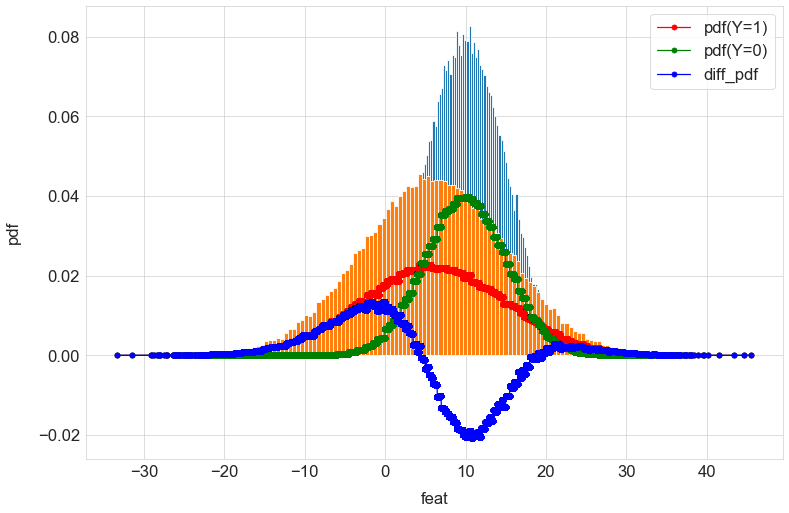

In [20]:
mpl.rcParams['agg.path.chunksize'] = 10000
plt.figure(figsize=(15,10),dpi=60,linewidth = 2)
plt.hist(df.loc[df[Y]==0,X],bins=bins,density=True)
plt.hist(df.loc[df[Y]==1,X],bins=bins,density=True)

plt.plot(df['feat'],df['feat_Y=1_pdf'],'o-',color = 'r', label="pdf(Y=1)")
plt.plot(df['feat'],df['feat_Y=0_pdf'],'o-',color = 'g', label="pdf(Y=0)")
plt.plot(df['feat'],df['diff_pdf'],'o-',color = 'b', label="diff_pdf")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# 標示x,y軸(labelpad代表與圖片的距離)
plt.xlabel("feat", fontsize=20, labelpad = 15)
plt.ylabel("pdf", fontsize=20, labelpad = 20)
# 顯示出線條標記位置
plt.legend(loc = "best", fontsize=20)

plt.show()